In [347]:
import pandas as pd
import numpy as np
import PythonMagick
from PIL import Image
import re

%matplotlib inline



In [367]:
DOWNSCALED_WIDTH=400

def downscale(img):
    o_width, o_height = img.size
    height = round((DOWNSCALED_WIDTH/o_width) * o_height)
    
    ds_img = img.resize((DOWNSCALED_WIDTH, height), resample=Image.BILINEAR)
    ds_img.show()
    
    return ds_img

def pixels_df(img):
    pixels = list(img.getdata())
    width, height = img.size
    pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]

    return pd.DataFrame(pixels)


In [372]:
original = Image.open("../input/scan0027.jpg")

img = downscale(original)
df = pixels_df(img)

print("Shape of matrix is %dx%d" % (df.shape))


# 0 = white, 1 = black pixels
contrasted = df.applymap(lambda x: int(np.sqrt(x) if x < 127 else x**2) / (255**2))
contrasted.describe()

Shape of matrix is 286x400


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,...,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000
mean,0.995904,0.993114,0.996690,0.997565,0.998605,0.998933,0.999425,0.999507,0.999562,0.999644,...,0.997159,0.999457,0.999647,0.999540,0.999460,0.999354,0.999407,0.999407,0.999354,0.999809
std,0.007319,0.007032,0.004535,0.003914,0.003274,0.002845,0.002147,0.002013,0.001802,0.001633,...,0.005866,0.004421,0.003575,0.004762,0.005715,0.006929,0.006321,0.006321,0.006929,0.001896
min,0.923106,0.945852,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.992172,0.992172,...,0.945852,0.945852,0.953495,0.938239,0.923106,0.908097,0.915586,0.915586,0.908097,0.976609
25%,0.992172,0.992172,0.992172,0.992172,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.992172,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,0.992172,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


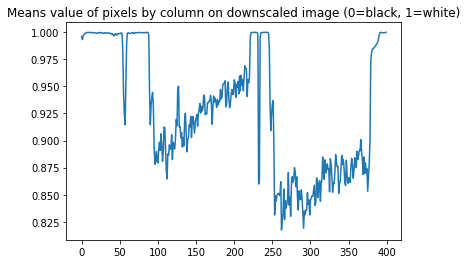

In [374]:
means = contrasted.mean()
means.plot(title="Means value of pixels by column on downscaled image (0=black, 1=white)")

In [375]:
# means.head(10)

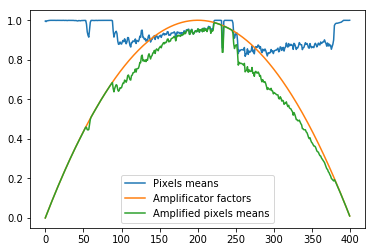

In [376]:
def apply_func_factory(serie):
    center = len(serie)/2

    def apply_func(x):
        idx = x.name
        return 1 - (abs(center - idx) ** 2) / center**2
    
    return apply_func
    

apply_func = apply_func_factory(means)

factors = means.reset_index().apply(apply_func, axis=1)

means.plot(label="Pixels means", legend=True)
factors.plot(label="Amplificator factors", legend=True)
final = means * factors
final.plot(label="Amplified pixels means", legend=True)

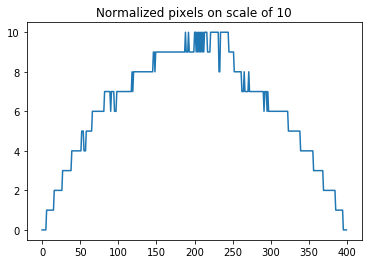

In [377]:
normalized = (final * 10).round()
normalized.plot(title="Normalized pixels on scale of 10")

In [378]:
grouped = normalized.reset_index().groupby(normalized, as_index=False)

# luminosity distinct sorted values (10 at max = whitest)
lum_val = grouped[0].last().round().values.flatten()
lum_val.sort()
whitest = lum_val[-1]

# whitests columns (maximum of luminosity)
white_cols = grouped.get_group(whitest)['index']
    
if len(white_cols) < 0.02 * DOWNSCALED_WIDTH:
    white_cols = white_cols.append(grouped.get_group(lum_val[-2])['index'])


In [329]:
first_idx, last_idx = white_cols.min(), white_cols.max()
margin = max(1, round(0.005 * DOWNSCALED_WIDTH))
white_band = normalized[first_idx-margin:last_idx+margin]


# we have a dark local minimum in the white band
band_min = white_band.min()
print("Darkest inside white band: %s" % band_min)

Darkest inside white band: 9.0


In [330]:
if band_min <= whitest - 2:
    median_columns = normalized[first_idx-margin:last_idx+margin]
    dark_inside_median = median_columns[median_columns == band_min].reset_index()['index']
    print("Dark inside median %s" % dark_inside_median)
    binding_point = dark_inside_median.median()
    print("For a width of %d, split at pixel %f (median in dark range around middle)" % (DOWNSCALED_WIDTH, binding_point))
else:
    # binding as median of indexes
    binding_point = indexes.median()
    print("For a width of %d, split at pixel %f (median of maximum)" % (DOWNSCALED_WIDTH, binding_point))

For a width of 400, split at pixel 144.000000 (median of maximum)


In [321]:
o_width, _ = original.size
cut_x = round(o_width * (binding_point / DOWNSCALED_WIDTH))
print("Split image must occurs at X=%d" % cut_x)

Split image must occurs at X=833


In [314]:
regex = re.compile(r"\D+(?P<left>[0-9]+)(?:[-_](?P<right>[0-9]+))?\.jpg$")

def splitted_pages_numbers(filename):
    match = regex.search(filename)

    # page names as numbers
    # left = int(match.group('left'))
    # right = int(match.group('right') or left + 1)

    # page names as suffixed from original
    left = match.group('left') + "-a"
    right = match.group('right') or (match.group('left') + "-b")

    return { "left": left, "right": right }


In [315]:
def output_path(page_n):
    return "../output/page-%s.jpg" % page_n

def split_pages_paths(original_filename):
    pages_numbers = splitted_pages_numbers(original_filename)
    
    return {
        "left": output_path(pages_numbers["left"]),
        "right": output_path(pages_numbers["right"]),
    }
    
    
def horizontal_split(img, cut_x):
    dimLeft = (0, 0, cut_x - 1, img.height)
    print("Dimensions left=%s" % str(dimLeft))
    imgLeft = img.crop(dimLeft)
    
    dimRight = (cut_x, 0, img.width, img.height)
    print("Dimensions right=%s" % str(dimRight))
    imgRight = img.crop(dimRight)
    

    file_paths = split_pages_paths(img.filename)
    
    imgLeft.save(file_paths['left'])
    imgRight.save(file_paths['right'])
    
    print("Saved 2 images: %s" % str(file_paths))

horizontal_split(original, cut_x)

Dimensions left=(0, 0, 832, 2480)
Dimensions right=(833, 0, 3472, 2480)
Saved 2 images: {'left': '../output/page-0027-a.jpg', 'right': '../output/page-0027-b.jpg'}
